In [32]:
import numpy
import tqdm
import pandas
import conntility
import json
import connalysis
import os

from matplotlib import pyplot as plt

from scipy import sparse
from scipy.spatial.distance import pdist, squareform

import nngraphmdl

## Load neuron locations

We load neuron locations in a central cube of the microns data.
Later, we wire up the neurons based on their locations.
This allows us to compare generated connectivity directly to microns.

In [233]:
# UPDATE PATH. WHERE CAN I FIND THE MICRONS CONNECTOME?
microns_connectome_prefix = "/home/reimann/Documents/data/microns/"

with open("../configs/attempt_L45E_microns.json", "r") as fid:
    cfg = json.load(fid)

cfg["make_points"]["fn"] = os.path.join(microns_connectome_prefix, cfg["make_points"]["fn"])

pts, pts_sub, microns = nngraphmdl.points_from_microns(cfg["make_points"])
reference = microns.matrix > 0

12881


In [227]:
print(microns.vertices["cell_type"].value_counts())

cell_type
L4b     4790
L4a     2353
L4c     1891
L5b     1615
L5ET     922
L5a      827
L5NP     483
Name: count, dtype: int64


## Meta-model
We generate a number of matrices that determine how the model works out.

In [234]:
M12, M22, M21, M11 = nngraphmdl.make_matrices(pts, pts_sub, cfg["make_matrices"])

In [162]:
#M21 = sparse.csc_matrix(M21 / (M21.sum(axis=0) + 1E-12))

## Create stochastic connectome

In [235]:
N, stats_lvl1, stats_lvl2 = nngraphmdl.wire(M12, M22, M21, M11, pts, pts_sub, cfg["wire"])

In [236]:
print(N.nnz)
print(reference.nnz)

631896
616553


## Comparison

### 1: How neuron degrees change with depth

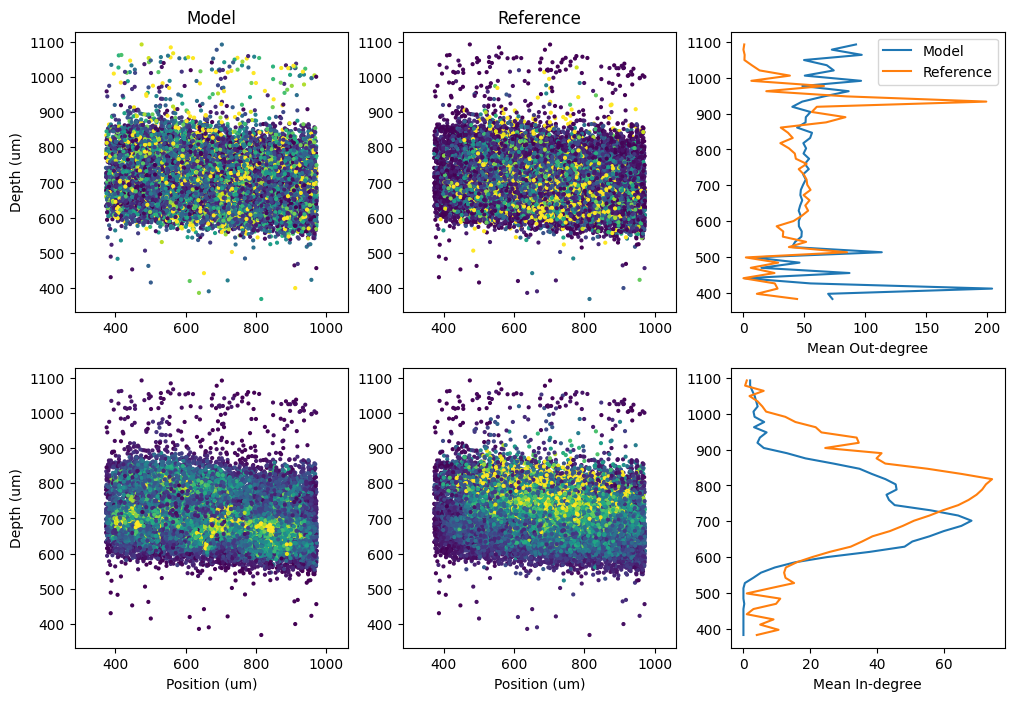

In [237]:
def plot_degrees(model, reference, nbins):
    ybins = numpy.linspace(pts[:, 1].min(), pts[:, 1].max() + 1E-3, nbins)
    df = pandas.DataFrame({"indegree_model": numpy.array(model.sum(axis=0))[0],
                           "indegree_ref": numpy.array(reference.sum(axis=0))[0],
                           "outdegree_model": numpy.array(model.sum(axis=1))[:, 0],
                           "outdegree_ref": numpy.array(reference.sum(axis=1))[:, 0],
                           "ybin": numpy.digitize(pts[:, 1], bins=ybins)})
    df_mn = df.groupby("ybin").mean()
    df_mn.index = ybins[df_mn.index]

    clim_out = (0.0, numpy.maximum(numpy.percentile(df["outdegree_model"], 90),
                                   numpy.percentile(df["outdegree_ref"], 90)))
    clim_in = (0.0, numpy.maximum(numpy.percentile(df["indegree_model"], 90),
                                   numpy.percentile(df["indegree_ref"], 90)))
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(2, 3, 1)
    ax.scatter(pts[:, 0], pts[:, 1], c=df["outdegree_model"], s=4, clim=clim_out)
    ax.set_ylabel("Depth (um)")
    ax.set_title("Model")
    plt.axis("equal")

    ax = fig.add_subplot(2, 3, 2)
    ax.scatter(pts[:, 0], pts[:, 1], c=df["outdegree_ref"], s=4, clim=clim_out)
    ax.set_title("Reference")
    plt.axis("equal")
    
    ax = fig.add_subplot(2, 3, 3)
    ax.plot(df_mn["outdegree_model"], df_mn.index, label="Model")
    ax.plot(df_mn["outdegree_ref"], df_mn.index, label="Reference")
    ax.set_xlabel("Mean Out-degree")
    plt.legend()
    
    ax = fig.add_subplot(2, 3, 4)
    ax.scatter(pts[:, 0], pts[:, 1], c=df["indegree_model"], s=4, clim=clim_out)
    ax.set_ylabel("Depth (um)")
    ax.set_xlabel("Position (um)")
    plt.axis("equal")

    ax = fig.add_subplot(2, 3, 5)
    ax.scatter(pts[:, 0], pts[:, 1], c=df["indegree_ref"], s=4, clim=clim_out)
    ax.set_xlabel("Position (um)")
    plt.axis("equal")
    
    ax = fig.add_subplot(2, 3, 6)
    ax.plot(df_mn["indegree_model"], df_mn.index, label="Model")
    ax.plot(df_mn["indegree_ref"], df_mn.index, label="Reference")
    ax.set_xlabel("Mean In-degree")
    return df

df_degrees = plot_degrees(N, reference, 51)


### 2: Distributions of in/out-degrees

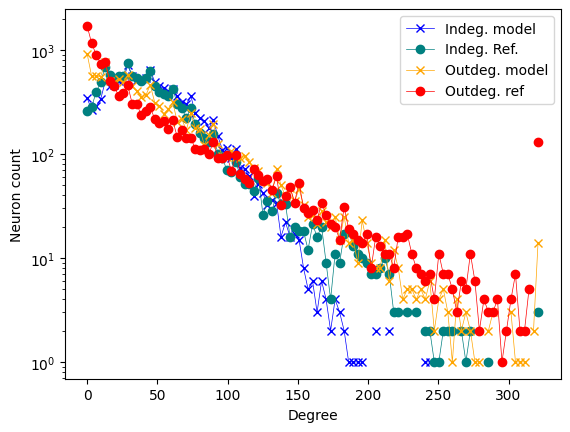

In [238]:
nbins = 101

_cols = df_degrees.columns[:-1]
mx_degree = df_degrees[_cols].apply(lambda _x: numpy.percentile(_x, 99)).max()
deg_bins = numpy.linspace(0, mx_degree, nbins)
df_dgtz = df_degrees[_cols].apply(lambda _x: numpy.digitize(_x, bins=deg_bins) - 1)
df_count = df_dgtz.apply(lambda _x: _x.value_counts().sort_index())

fig = plt.figure()

ax = fig.gca()

ax.plot(deg_bins[df_count.index], df_count["indegree_model"], marker='x', lw=0.5, color="blue", label="Indeg. model")
ax.plot(deg_bins[df_count.index], df_count["indegree_ref"], marker='o', lw=0.5, color="teal", label="Indeg. Ref.")
ax.plot(deg_bins[df_count.index], df_count["outdegree_model"], marker='x', lw=0.5, color="orange", label="Outdeg. model")
ax.plot(deg_bins[df_count.index], df_count["outdegree_ref"], marker='o', lw=0.5, color="red", label="Outdeg. ref")

ax.set_xlabel("Degree")
ax.set_ylabel("Neuron count")
ax.set_yscale("log")
plt.legend()

### 3: Connection probability against distance

/tmp/ipykernel_5546/1893019468.py:12: RuntimeWarning: invalid value encountered in divide
  ax.plot(dbins[:-1], H_con_mdl / H_all, color=[0.35, 0.7, 0.35], label="Model")
/tmp/ipykernel_5546/1893019468.py:13: RuntimeWarning: invalid value encountered in divide
  ax.plot(dbins[:-1], H_con_ref / H_all, color=[0.2, 0.9, 0.2], label="Reference")


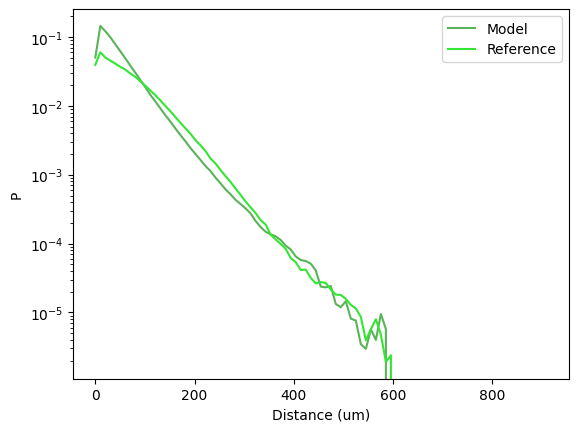

In [239]:
dbins = numpy.linspace(0, 1000, 100)

D = squareform(pdist(pts))
Ncoo = N.tocoo(); refcoo = reference.tocoo()

H_all = numpy.histogram(D.flatten(), bins=dbins)[0]
H_con_mdl = numpy.histogram(D[Ncoo.row, Ncoo.col], bins=dbins)[0]
H_con_ref = numpy.histogram(D[refcoo.row, refcoo.col], bins=dbins)[0]

fig = plt.figure()
ax = fig.gca()
ax.plot(dbins[:-1], H_con_mdl / H_all, color=[0.35, 0.7, 0.35], label="Model")
ax.plot(dbins[:-1], H_con_ref / H_all, color=[0.2, 0.9, 0.2], label="Reference")
plt.gca().set_yscale("log")
ax.set_xlabel("Distance (um)"); ax.set_ylabel("P")
plt.legend()

[[-0.40128017 -0.86333224 -0.30599293]
 [ 0.89941925 -0.30820562 -0.3099263 ]
 [-0.17326062  0.39958321 -0.90017444]]


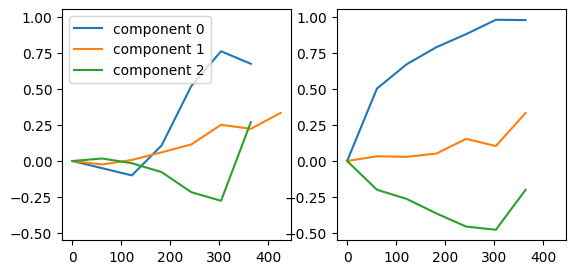

In [240]:
from sklearn.decomposition import PCA

def connection_directionality_analysis_w(sparse_mat, vertex_props, *args, **kwargs):
    con_mat = conntility.ConnectivityMatrix(sparse_mat, vertex_properties=vertex_props)
    return connection_directionality_analysis(con_mat, *args, **kwargs)

def connection_directionality_analysis(con_mat, nbins, max_dist, pca=None):
    deltas = pandas.DataFrame(dict([
        (_prop, numpy.diff(con_mat.edge_associated_vertex_properties(_prop).values / 1000, axis=1).flatten())
        for _prop in ["x_nm", "y_nm", "z_nm"]
    ]))    

    if pca is None:
        pca = PCA()
        pca_res = pca.fit_transform(deltas[["x_nm", "y_nm", "z_nm"]])
    else:
        pca_res = pca.transform(deltas[["x_nm", "y_nm", "z_nm"]])

    dbins = numpy.linspace(0, max_dist, nbins)
    counters = []
    for i in range(3):
        vc = pandas.Series(dbins[numpy.digitize(numpy.abs(pca_res[:, i]), bins=dbins) - 1]
                            * numpy.sign(pca_res[:, i])).value_counts()
        counters.append(vc)
    counters = pandas.concat(counters, axis=1, keys=["component {0}".format(i) for i in range(3)])
    return counters, pca

fig = plt.figure(figsize=(6.5, 3))
ax = fig.add_subplot(1, 2, 1)
dir_res, pca = connection_directionality_analysis(microns, 15, 850)
print(pca.components_)
dir_res_cp = dir_res.copy()
dir_res_cp.index = -dir_res_cp.index
dir_res_plt = (dir_res - dir_res_cp) / (dir_res + dir_res_cp)
dir_res_plt[(dir_res + dir_res_cp) < 50] = numpy.NaN

for _col in dir_res.columns:
    plt.plot(dir_res_plt[_col][dir_res_plt.index >= 0].sort_index(), label=_col)
plt.legend()
        

fig.add_subplot(1, 2, 2, sharey=ax, sharex=ax)
dir_res, components = connection_directionality_analysis_w(N, microns._vertex_properties, 15, 850, pca=pca)
dir_res_cp = dir_res.copy()
dir_res_cp.index = -dir_res_cp.index
dir_res_plt = (dir_res - dir_res_cp) / (dir_res + dir_res_cp)
dir_res_plt[(dir_res + dir_res_cp) < 50] = numpy.NaN

for _col in dir_res.columns:
    plt.plot(dir_res_plt[_col][dir_res_plt.index >= 0].sort_index())
        

In [25]:
# from scipy.stats import binom

# def test_p(ab):
#     a = ab["a"]; b = ab["b"]
#     n = a + b
#     p = numpy.minimum(binom(n, 0.5).cdf(a), binom(n, 0.5).cdf(b))
#     return -numpy.log10(p) * numpy.sign(a - b)

# plt.figure()
# dir_res, components = connection_directionality_analysis(microns, 15, 850, pca=pca)
# dir_res_cp = dir_res.copy()
# dir_res_cp.index = -dir_res_cp.index
# foo = pandas.concat([dir_res, dir_res_cp], axis=1, keys=["a", "b"], names=["dir"])
# foo = foo.stack(-1).apply(test_p, axis=1)
# dir_res_plt = foo.unstack()


# for _col in dir_res.columns:
#     plt.plot(dir_res_plt[_col][dir_res_plt.index >= 0].sort_index())

### 4: Simplex counts and simplex counts in controls

In [241]:
import connalysis

def simplex_counts_and_controls(matrix):
    O = matrix.tocsc()
    keys = []
    res = []

    _N = connalysis.randomization.ER_shuffle(O)
    keys.append("ER")
    res.append(connalysis.network.simplex_counts(_N.astype(bool), max_dim=10))

    _N = connalysis.randomization.configuration_model(O)
    keys.append("Config. model")
    res.append(connalysis.network.simplex_counts(_N.astype(bool), max_dim=10))
    
    _N = connalysis.randomization.bishuffled_model(O)
    keys.append("Bishuffled model")
    res.append(connalysis.network.simplex_counts(_N.astype(bool), max_dim=10))

    keys.append("Original")
    res.append(connalysis.network.simplex_counts(O, max_dim=10))
    return pandas.concat(res, axis=0, keys=keys)

smplx_model = simplex_counts_and_controls(N).unstack(fill_value=0)
smplx_ref = simplex_counts_and_controls(reference).unstack(fill_value=0)

 2024-10-30 00:13:19,162: No seed among keyword arguments
 2024-10-30 00:13:19,274: Shuffle 631896 edges following Erdos-Renyi
/home/reimann/venvs/bpsnap/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
 2024-10-30 00:13:37,451: No seed among keyword arguments
 2024-10-30 00:13:37,557: Shuffle 616553 edges following Erdos-Renyi
/home/reimann/venvs/bpsnap/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Text(0, 0.5, 'Count')

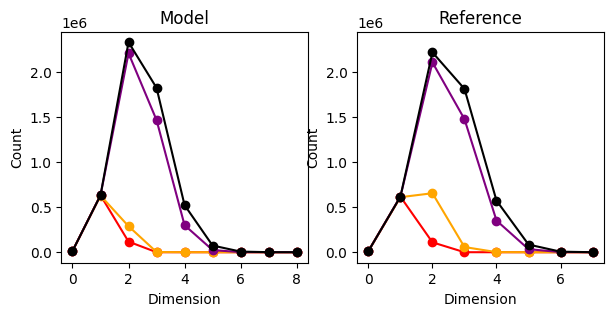

In [242]:
fig = plt.figure(figsize=(7, 3))

cols = {"Original": "black", "ER": "red", "Config. model": "orange", "Bishuffled model": "purple"}

ax = fig.add_subplot(1, 2, 1)
for mdl in smplx_model.index:
    ax.plot(smplx_model.loc[mdl], label=mdl, color=cols[mdl], marker='o')
ax.set_title("Model")
ax.set_xlabel("Dimension"); ax.set_ylabel("Count")

ax = fig.add_subplot(1, 2, 2, sharey=ax)
for mdl in smplx_ref.index:
    ax.plot(smplx_ref.loc[mdl], label=mdl, color=cols[mdl], marker='o')
ax.set_title("Reference")
ax.set_xlabel("Dimension"); ax.set_ylabel("Count")

### 5: How Connectivity increases when the nearest neighbor is connected
Hint: Similar to what we did for the human model project.

/tmp/ipykernel_4912/2509622286.py:26: RuntimeWarning: invalid value encountered in divide
  P_con_mdl = H_con_mdl / H_all
/tmp/ipykernel_4912/2509622286.py:24: RuntimeWarning: invalid value encountered in divide
  return H_x_con / H_x_all
/tmp/ipykernel_4912/2509622286.py:30: RuntimeWarning: invalid value encountered in divide
  P_con_ref = H_con_ref / H_all
/tmp/ipykernel_4912/2509622286.py:37: RuntimeWarning: invalid value encountered in divide
  plt.plot(dbins[:-1], (P_x_con_mdl_e - P_con_mdl) / (P_x_con_mdl_e + P_con_mdl),
/tmp/ipykernel_4912/2509622286.py:39: RuntimeWarning: invalid value encountered in divide
  plt.plot(dbins[:-1], (P_x_con_ref_e - P_con_ref) / (P_x_con_ref_e + P_con_ref),
/tmp/ipykernel_4912/2509622286.py:44: RuntimeWarning: invalid value encountered in divide
  plt.plot(dbins[:-1], (P_x_con_ref_a - P_con_ref) / (P_x_con_ref_a + P_con_ref),


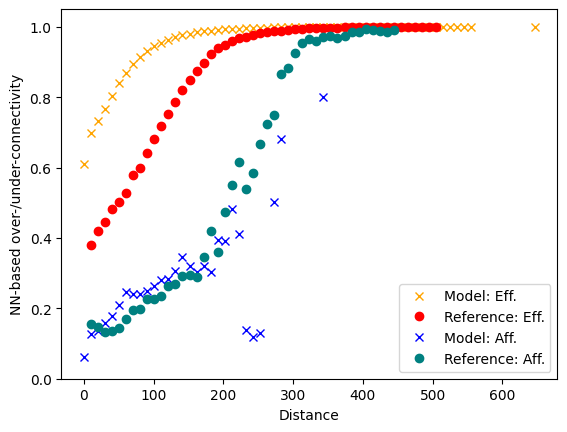

In [28]:
from scipy.spatial import KDTree

def dist_and_nn_analysis(matrix, pts, D, dbins, direction="efferent"):
    if direction == "efferent":
        O = matrix.tocsr()
    elif direction == "afferent":
        O = matrix.tocsc()

    kd = KDTree(pts)
    _, idx = kd.query(pts, numpy.arange(2, 3))
    idx = idx[:, 0]

    dists_x_all = []; dists_x_con = []
    for i, ab in enumerate(zip(O.indptr[:-1], O.indptr[1:])):
        a, b = ab
        __idx = O.indices[a:b]
        nn_idx = idx[__idx]  # indices of neurons that have their nearest neighbor being connected
        is_con = numpy.in1d(nn_idx, __idx)
        _d = D[i, nn_idx]
        dists_x_all.extend(_d)  # distances of neurons that have their nn connected
        dists_x_con.extend(_d[is_con])  # distances of neurons that have their nn connected and themselves connected
    H_x_all = numpy.histogram(dists_x_all, bins=dbins)[0]
    H_x_con = numpy.histogram(dists_x_con, bins=dbins)[0]
    return H_x_con / H_x_all

P_con_mdl = H_con_mdl / H_all
P_x_con_mdl_e = dist_and_nn_analysis(N, pts, D, dbins)
P_x_con_mdl_a = dist_and_nn_analysis(N, pts, D, dbins, direction="afferent")

P_con_ref = H_con_ref / H_all
P_x_con_ref_e = dist_and_nn_analysis(reference, pts, D, dbins)
P_x_con_ref_a = dist_and_nn_analysis(reference, pts, D, dbins, direction="afferent")

fig = plt.figure()
ax = fig.gca()

plt.plot(dbins[:-1], (P_x_con_mdl_e - P_con_mdl) / (P_x_con_mdl_e + P_con_mdl),
         color="orange", marker="x", ls="None", label="Model: Eff.")
plt.plot(dbins[:-1], (P_x_con_ref_e - P_con_ref) / (P_x_con_ref_e + P_con_ref),
         color="red", marker="o", ls="None", label="Reference: Eff.")

plt.plot(dbins[:-1], (P_x_con_mdl_a - P_con_mdl) / (P_x_con_mdl_a + P_con_mdl),
         color="blue", marker="x", ls="None", label="Model: Aff.")
plt.plot(dbins[:-1], (P_x_con_ref_a - P_con_ref) / (P_x_con_ref_a + P_con_ref),
         color="teal", marker="o", ls="None", label="Reference: Aff.")
ax.set_xlabel("Distance")
ax.set_ylabel("NN-based over-/under-connectivity")
ax.set_ylim([0, 1.05])
plt.legend()

In [29]:
ep_ref = connalysis.network.topology.edge_participation(reference)
ep_mdl = connalysis.network.topology.edge_participation(N)

Done running flagser
Done running flagser


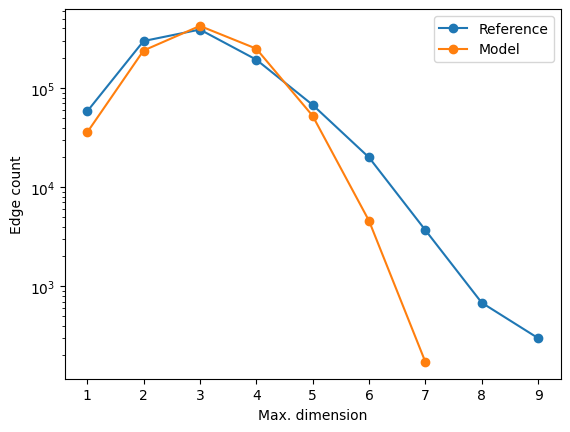

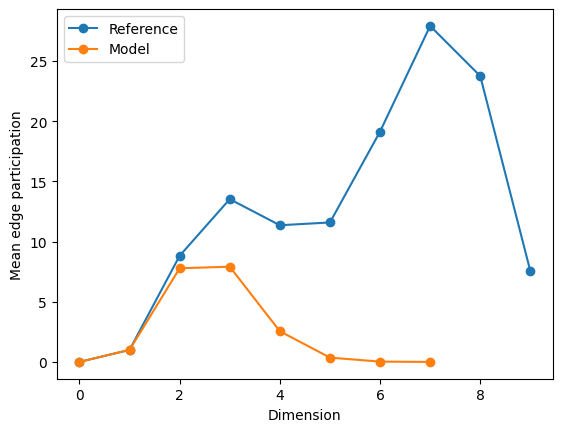

In [30]:
mxdim_ref = (ep_ref > 0).sum(axis=1)
mxdim_mdl = (ep_mdl > 0).sum(axis=1)

fig = plt.figure()
ax = fig.gca()

ax.plot(mxdim_ref.value_counts().sort_index(), marker="o", label="Reference")
ax.plot(mxdim_mdl.value_counts().sort_index(), marker="o", label="Model")
ax.set_xlabel("Max. dimension")
ax.set_ylabel("Edge count")
plt.legend()
ax.set_yscale('log')

fig = plt.figure()
ax = fig.gca()

xx = smplx_model.columns
n_edges = xx * (xx + 1) / 2

ax.plot(ep_ref.mean(), marker="o", label="Reference")
ax.plot(ep_mdl.mean(), marker="o", label="Model")
ax.set_xlabel("Dimension")
ax.set_ylabel("Mean edge participation")
plt.legend()

In [ ]:
smpl_list = connalysis.network.topology.list_simplices_by_dimension(reference)
rc_ref = smpl_list[1:].apply(connalysis.network.topology.count_rc_edges_k_skeleton, args=(len(pts), ))

smpl_list = connalysis.network.topology.list_simplices_by_dimension(N)
rc_mdl = smpl_list[1:].apply(connalysis.network.topology.count_rc_edges_k_skeleton, args=(len(pts), ))

 2024-10-29 21:42:03,215: COMPUTE list of simplices by dimension


(0.0, 25.0)

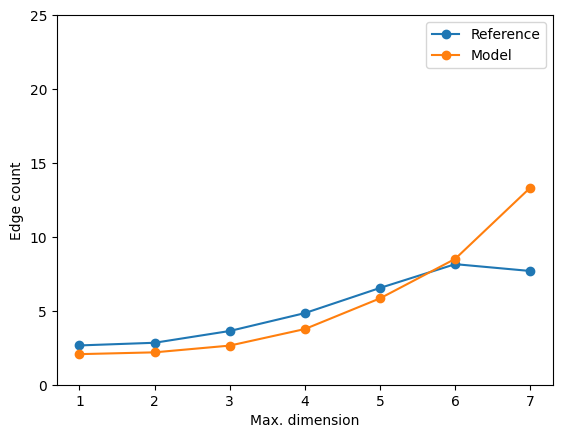

In [82]:
fig = plt.figure()
ax = fig.gca()

ax.plot(100 * rc_ref.apply(lambda tpl: tpl[1]/tpl[0]), marker="o", label="Reference")
ax.plot(100 * rc_mdl.apply(lambda tpl: tpl[1]/tpl[0]), marker="o", label="Model")
ax.set_xlabel("Max. dimension")
ax.set_ylabel("Edge count")
plt.legend()

ax.set_ylim([0, 25])


In [83]:
smpl_list = connalysis.network.topology.list_simplices_by_dimension(reference)
rc_ref = smpl_list[1:].apply(connalysis.network.topology.count_rc_edges_k_skeleton, args=(len(pts), ), position="spine")

smpl_list = connalysis.network.topology.list_simplices_by_dimension(N)
rc_mdl = smpl_list[1:].apply(connalysis.network.topology.count_rc_edges_k_skeleton, args=(len(pts), ), position="spine")

 2024-10-29 16:29:16,303: COMPUTE list of simplices by dimension
 2024-10-29 16:29:21,189: COMPUTE list of simplices by dimension


(0.0, 55.0)

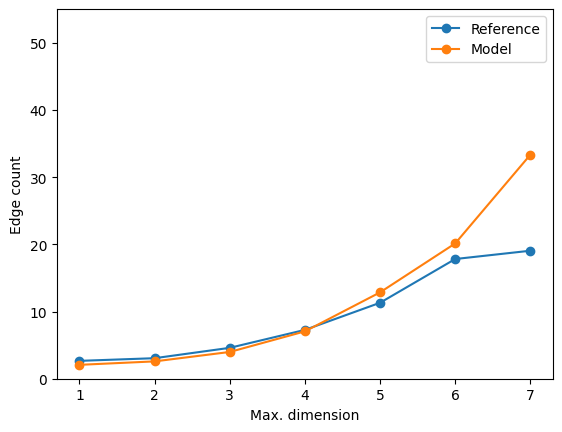

In [84]:
fig = plt.figure()
ax = fig.gca()

ax.plot(100 * rc_ref.apply(lambda tpl: tpl[1]/tpl[0]), marker="o", label="Reference")
ax.plot(100 * rc_mdl.apply(lambda tpl: tpl[1]/tpl[0]), marker="o", label="Model")
ax.set_xlabel("Max. dimension")
ax.set_ylabel("Edge count")
plt.legend()

ax.set_ylim([0, 55])
